In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv("internet_access_data.csv")
df.drop(columns = ["Flag Codes"], inplace = True)
df.head(100)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value
0,BEL,INTERNET,TOT,PC_HH,A,2005,50.157500
1,BEL,INTERNET,TOT,PC_HH,A,2006,53.959700
2,BEL,INTERNET,TOT,PC_HH,A,2007,60.164000
3,BEL,INTERNET,TOT,PC_HH,A,2008,63.627600
4,BEL,INTERNET,TOT,PC_HH,A,2009,67.435200
...,...,...,...,...,...,...,...
95,FRA,INTERNET,TOT,PC_HH,A,2013,81.719200
96,FRA,INTERNET,TOT,PC_HH,A,2014,82.955600
97,FRA,INTERNET,TOT,PC_HH,A,2015,82.620700
98,FRA,INTERNET,TOT,PC_HH,A,2016,85.873600


In [26]:
df.isna().sum().any()

np.False_

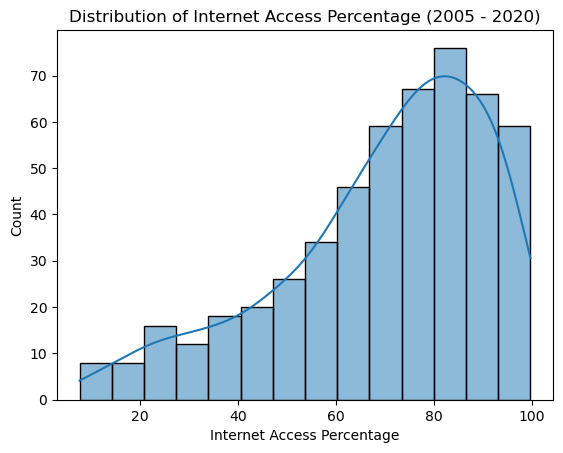

In [27]:
sns.histplot(data = df["Value"], kde=True)  
plt.xlabel("Internet Access Percentage")
plt.ylabel("Count")
plt.title("Distribution of Internet Access Percentage (2005 - 2020)")
plt.show()


In [28]:
df["LOCATION"].value_counts().head(25)

LOCATION
BEL    15
DNK    15
DEU    15
AUT    15
CZE    15
POL    15
NLD    15
CRI    15
LTU    15
ESP    15
FIN    15
IRL    15
GRC    15
NOR    15
KOR    15
MEX    15
GBR    15
PRT    15
SVN    15
ITA    15
LUX    15
HUN    15
SVK    15
SWE    15
LVA    15
Name: count, dtype: int64

In [29]:
df[df["LOCATION"].isin(df["LOCATION"].value_counts().head(25).index)]

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value
0,BEL,INTERNET,TOT,PC_HH,A,2005,50.157500
1,BEL,INTERNET,TOT,PC_HH,A,2006,53.959700
2,BEL,INTERNET,TOT,PC_HH,A,2007,60.164000
3,BEL,INTERNET,TOT,PC_HH,A,2008,63.627600
4,BEL,INTERNET,TOT,PC_HH,A,2009,67.435200
...,...,...,...,...,...,...,...
510,CRI,INTERNET,TOT,PC_HH,A,2015,60.181183
511,CRI,INTERNET,TOT,PC_HH,A,2016,64.800000
512,CRI,INTERNET,TOT,PC_HH,A,2017,68.600000
513,CRI,INTERNET,TOT,PC_HH,A,2018,73.080247


Text(0, 0.5, 'Internet Access Score')

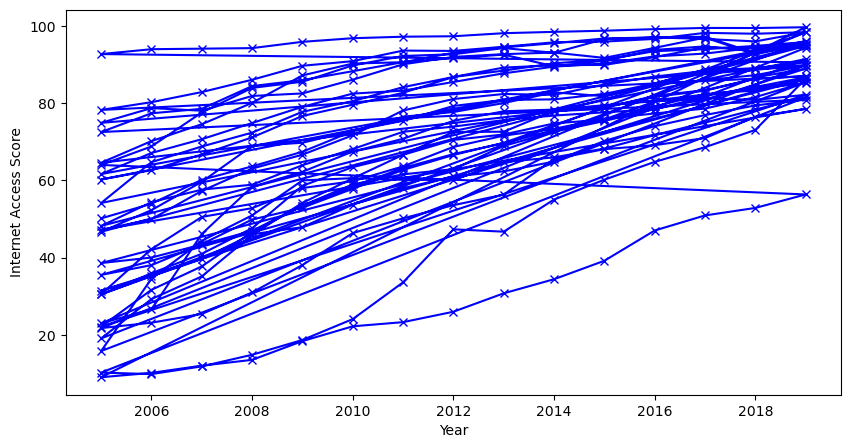

In [30]:
x = df[df["LOCATION"].isin(df["LOCATION"].value_counts().head(25).index)]["TIME"]
y = df[df["LOCATION"].isin(df["LOCATION"].value_counts().head(25).index)]["Value"]
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='x', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Internet Access Score')

In [31]:
def create_dataset(dataset, bucket):
    X, y = [], []
    for i in range(len(dataset) - bucket):
        X.append(dataset[i: i + bucket])
        y.append(dataset[i + bucket])
    return np.array(X), np.array(y)

In [32]:
a = df[df["LOCATION"] == "BEL"]["Value"].values
print(a)
split_idx = int(len(a) * 0.75)
bucket = 3
X_train, y_train = create_dataset(a[:split_idx], bucket)
X_test, y_test = create_dataset(a[split_idx:], bucket)

[50.1575  53.9597  60.164   63.6276  67.4352  72.7371  76.5078  77.7137
 80.0478  82.8041  81.825   84.7857  85.96844 87.27254 89.73015]


In [33]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8, 3) (8,)
(1, 3) (1,)


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam

In [35]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=1, shuffle=False)

In [36]:
next(iter(train_loader))

[tensor([[63.6276, 67.4352, 72.7371]]), tensor([76.5078])]

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 22, num_layers = 2, output_size = 1):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size = 22, num_layers = 2, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size = 22, num_layers = 2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:, -1, :])
        x = self.relu(x)
        return x


In [38]:
model = LSTM()

In [39]:
from torchinfo import summary
summary(model, input_size=(1, 3, 1), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 1]                    --
├─LSTM: 1-1                              [1, 3, 22]                6,248
├─LSTM: 1-2                              [1, 3, 22]                8,096
├─Linear: 1-3                            [1, 1]                    23
├─ReLU: 1-4                              [1, 1]                    --
Total params: 14,367
Trainable params: 14,367
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06

In [40]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [41]:
def train(model, criterion, optimizer, train_loader, test_loader, epochs=50):
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.unsqueeze(-1)  # Add feature dimension
            output = model(X_batch) # Forward pass
            loss = criterion(output, y_batch)

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        #print(f"Epoch {epoch+1}/{epochs}, Average Loss: {epoch_loss/len(train_loader):.4f}")
        losses.append(epoch_loss / len(train_loader))

    
        if(epoch % 10 == 0):
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch = X_batch.unsqueeze(-1)  # Add feature dimension
                    output = model(X_batch)
                    loss = criterion(output, y_batch)
                    test_loss += loss.item()
            print(f"Epoch number: {epoch} Training Loss: {epoch_loss / len(train_loader):.4f} Test Loss: {test_loss / len(test_loader):.4f}")
    return losses


In [42]:
losses = train(model, criterion, optimizer, train_loader, test_loader, epochs=100)

c:\Users\natha\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number: 0 Training Loss: 543.4496 Test Loss: 7709.5371
Epoch number: 10 Training Loss: 390.3051 Test Loss: 4580.5112
Epoch number: 20 Training Loss: 228.6016 Test Loss: 2732.7085
Epoch number: 30 Training Loss: 24.9981 Test Loss: 1609.0576
Epoch number: 40 Training Loss: 39.8301 Test Loss: 959.5396
Epoch number: 50 Training Loss: 16.0447 Test Loss: 599.5014
Epoch number: 60 Training Loss: 8.4050 Test Loss: 406.9439
Epoch number: 70 Training Loss: 11.6537 Test Loss: 307.3841
Epoch number: 80 Training Loss: 1.9613 Test Loss: 254.8587
Epoch number: 90 Training Loss: 1.2200 Test Loss: 229.0399


C:\Users\natha\AppData\Local\Temp\ipykernel_5464\489916841.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


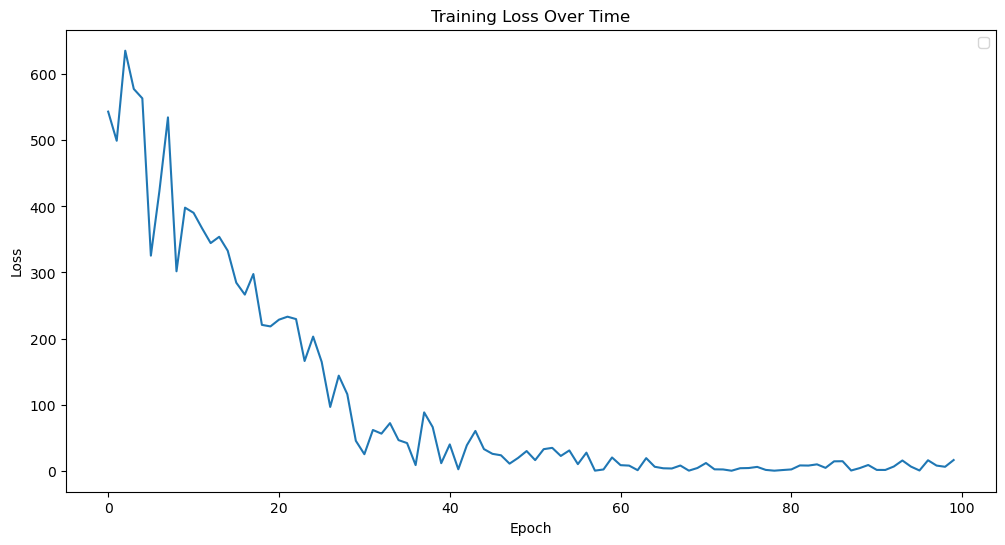

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [44]:
ls = df["LOCATION"].value_counts().head(25).index
ls

Index(['BEL', 'DNK', 'DEU', 'AUT', 'CZE', 'POL', 'NLD', 'CRI', 'LTU', 'ESP',
       'FIN', 'IRL', 'GRC', 'NOR', 'KOR', 'MEX', 'GBR', 'PRT', 'SVN', 'ITA',
       'LUX', 'HUN', 'SVK', 'SWE', 'LVA'],
      dtype='object', name='LOCATION')

c:\Users\natha\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[74.9174   78.7298   78.0544   81.8811   82.534    86.0984   90.0828
 91.9976   92.7135   93.1202   91.74     94.3436   97.00071  92.66406
 95.434314]
Country DNK
Epoch number: 0 Training Loss: 33.7844 Test Loss: 402.4338
Epoch number: 10 Training Loss: 0.0831 Test Loss: 160.4840
Epoch number: 20 Training Loss: 1.7115 Test Loss: 81.4567
Epoch number: 30 Training Loss: 4.5229 Test Loss: 56.6832
Epoch number: 40 Training Loss: 5.4294 Test Loss: 48.4363
Epoch number: 50 Training Loss: 1.3745 Test Loss: 45.5903
Epoch number: 60 Training Loss: 4.8376 Test Loss: 44.6264
Epoch number: 70 Training Loss: 1.9372 Test Loss: 44.3363
Epoch number: 80 Training Loss: 5.9906 Test Loss: 43.9917
Epoch number: 90 Training Loss: 4.9273 Test Loss: 43.8916


C:\Users\natha\AppData\Local\Temp\ipykernel_5464\4153268422.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


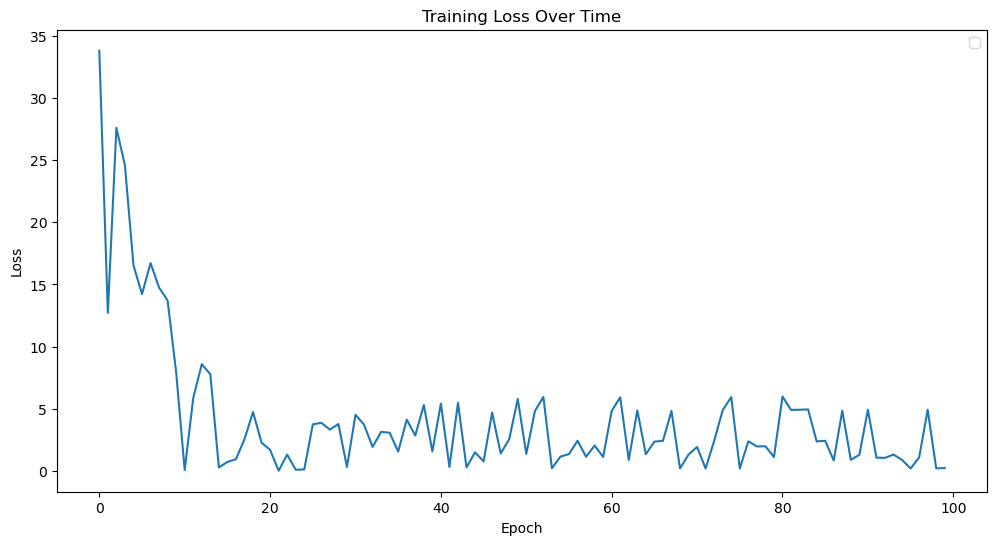

[35.5086  38.0418  43.4838  49.856   52.9288  57.8236  62.7077  66.5907
 69.7292  74.3549  78.7489  81.9309  83.38622 86.35764 91.43762]
Country ESP
Epoch number: 0 Training Loss: 41.0069 Test Loss: 14.5234
Epoch number: 10 Training Loss: 19.2107 Test Loss: 633.0753
Epoch number: 20 Training Loss: 26.2185 Test Loss: 737.9153
Epoch number: 30 Training Loss: 26.4061 Test Loss: 732.1208
Epoch number: 40 Training Loss: 25.2513 Test Loss: 749.0369
Epoch number: 50 Training Loss: 13.3448 Test Loss: 751.1368
Epoch number: 60 Training Loss: 0.2655 Test Loss: 744.3195
Epoch number: 70 Training Loss: 0.2189 Test Loss: 750.3337
Epoch number: 80 Training Loss: 0.3015 Test Loss: 739.1332
Epoch number: 90 Training Loss: 25.7432 Test Loss: 742.0732


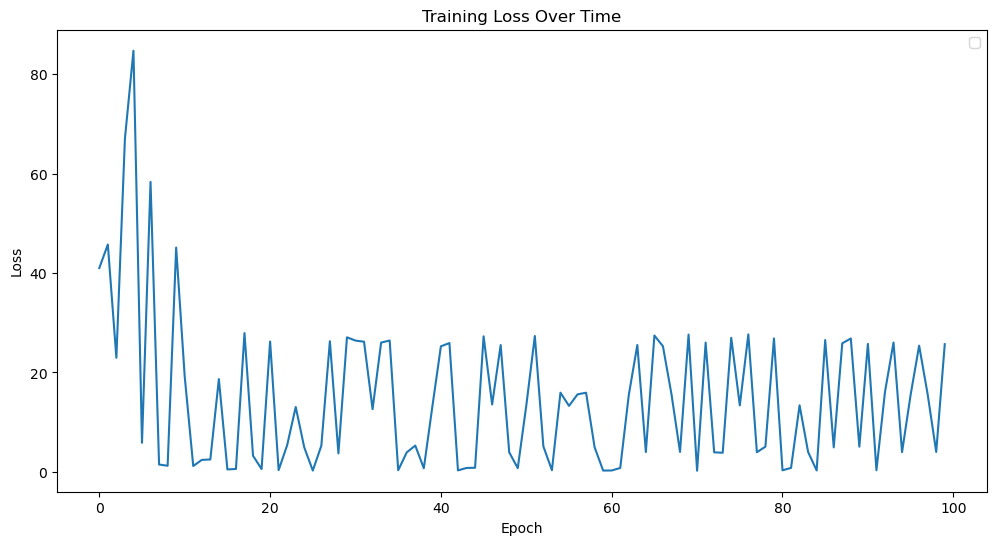

[31.4582   35.1534   39.6097   46.0427   47.8904   53.7319   57.9695
 61.0219   62.3417   64.8709   70.2348   74.0535   76.934963 79.42511
 80.93853 ]
Country PRT
Epoch number: 0 Training Loss: 31.5128 Test Loss: 297.3979
Epoch number: 10 Training Loss: 2.2938 Test Loss: 518.8220
Epoch number: 20 Training Loss: 2.2059 Test Loss: 519.3168
Epoch number: 30 Training Loss: 1.0780 Test Loss: 522.0715
Epoch number: 40 Training Loss: 2.2672 Test Loss: 526.4004
Epoch number: 50 Training Loss: 2.4043 Test Loss: 520.9935
Epoch number: 60 Training Loss: 13.0636 Test Loss: 520.5297
Epoch number: 70 Training Loss: 2.1018 Test Loss: 516.1423
Epoch number: 80 Training Loss: 2.3566 Test Loss: 526.6451
Epoch number: 90 Training Loss: 18.3305 Test Loss: 519.7452


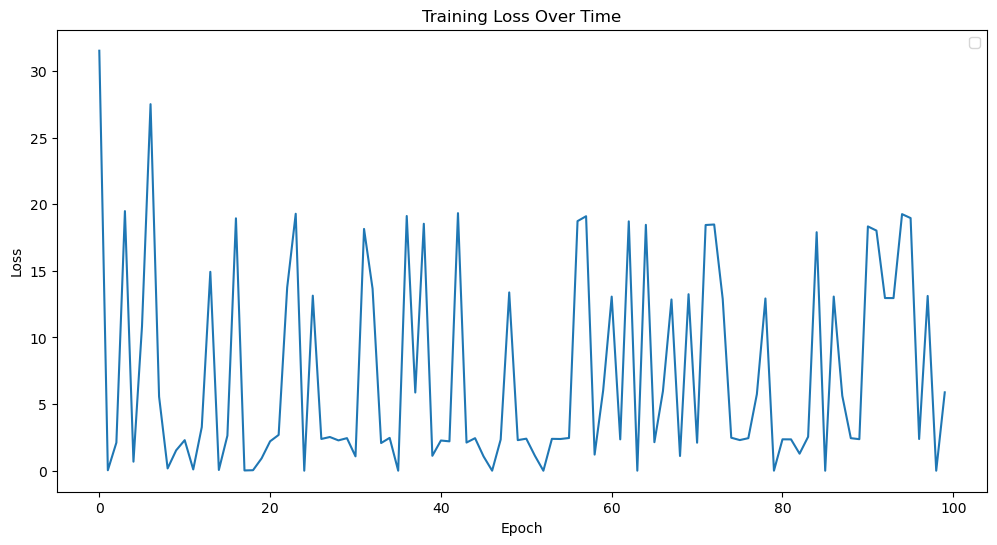

In [45]:
for i in range(1, len(ls), 8):
    a = df[df["LOCATION"] == ls[i]]["Value"].values
    print(a)
    split_idx = int(len(a) * 0.75)
    bucket = 3
    X_train, y_train = create_dataset(a[:split_idx], bucket)
    X_test, y_test = create_dataset(a[split_idx:], bucket)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=1, shuffle=False)
    print(f'Country {ls[i]}')
    losses = train(model, criterion, optimizer, train_loader, test_loader, epochs=100)
    plt.figure(figsize=(12, 6))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()